In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import itertools
from random import shuffle
import matplotlib.pyplot as plt
import cv2
from PIL import Image as pil_image
from math import sqrt
import random
from keras.utils import Sequence
from keras.layers import Input
# from lapjv import lapjv
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50,preprocess_input
from keras.applications.xception import Xception
from keras.layers.core import Activation, Dense, Dropout, Flatten, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import *
from keras.models import Sequential, Model
from collections import OrderedDict
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler


print(os.listdir("../input"))

Using TensorFlow backend.


['humpback-whale-identification', 'simple-cnn-classification']


In [2]:
DATA="../input/humpback-whale-identification"
TRAIN_IMG="../input/humpback-whale-identification/train"
TEST_IMG="../input/humpback-whale-identification/test"
BRANCH_MOD="../input/simple-cnn-classification/xception_model_finetune.h5"
SUBMISSION_Df = '../input/humpback-whale-identification/sample_submission.csv'
P2H_OUT = 'p2h.pickle'
IM_SIZE=150

In [3]:
test_df= pd.DataFrame({"Image":  os.listdir(TEST_IMG)})
print("test images:"+ str(len(test_df)))

test images:7960


In [4]:
train_lbl = pd.read_csv(os.path.join(DATA, 'train.csv'))
SUB_Df= pd.read_csv(os.path.join(DATA, 'sample_submission.csv'))
print("train images:"+ str(len(train_lbl)))
print("total unique class:"+ str(len(np.unique(train_lbl['Id']))))
train_lbl.head()

train images:25361
total unique class:5005


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [5]:
#take out whales with less than 2 examples
df=train_lbl.groupby(['Id']).size().reset_index(
    name='train_examples')
df=df[df['train_examples']<2]
single_whale_set= set(df.Id.values)
print("number of classes with less than 2 examples:"+ str(len(df)))
#remove whales with a single train example (2072 examples)
# train_lbl=train_lbl[train_lbl['Id'].isin(df_set)]
# print("number of train instances after removal:"+ str(len(train_lbl)))


number of classes with less than 2 examples:2073


In [6]:
def get_random_image(img_groups, group_names, gid):
    gname = group_names[gid]
    photos = img_groups[gname]
    pid = np.random.choice(np.arange(len(photos)), size=1)[0]
    pname = photos[pid]
    return pname
    
def create_triples(image_dir,labels,data_set='train'):
    img_groups = {}
    for img_file in tqdm(os.listdir(image_dir)):
        pid=img_file
        gid=labels[labels['Image']==pid].values[0][1] #this is the ralevant whale group
        if gid=='new_whale':continue
        if gid in single_whale_set: continue
#         if gid is None: continue
        if gid in img_groups:
            img_groups[gid].append(pid)
        else:
            img_groups[gid] = [pid]
    pos_triples, neg_triples = [], []
    # positive pairs are any combination of images in same group
    for key in img_groups.keys():
#         triples = [(key + x[0] , key + x[1] , 1) 
#                  for x in itertools.combinations(img_groups[key], 2)]
        triples = [(x[0] , x[1] , 1) 
                 for x in itertools.combinations(img_groups[key], 2)]
        pos_triples.extend(triples)
    # need equal number of negative examples
    group_names = list(img_groups.keys())
    for i in tqdm(range(len(pos_triples))):
        g1, g2 = np.random.choice(np.arange(len(group_names)), size=2, replace=False)
        left = get_random_image(img_groups, group_names, g1)
        right = get_random_image(img_groups, group_names, g2)
        neg_triples.append((left, right, 0))
    pos_triples.extend(neg_triples)
    shuffle(pos_triples)
    return pos_triples


triples_data = create_triples(TRAIN_IMG,train_lbl)

print(len(triples_data))
print("triplets examples:")
print(triples_data[0:5])


139874
triplets examples:
[('2cc404919.jpg', '6fd895fcb.jpg', 0), ('5bf17bb10.jpg', '821c2335e.jpg', 0), ('051fd9a67.jpg', '01f5b5205.jpg', 1), ('a89b7798c.jpg', '80efd7b6e.jpg', 1), ('dbe87da3b.jpg', 'a336b25cf.jpg', 0)]


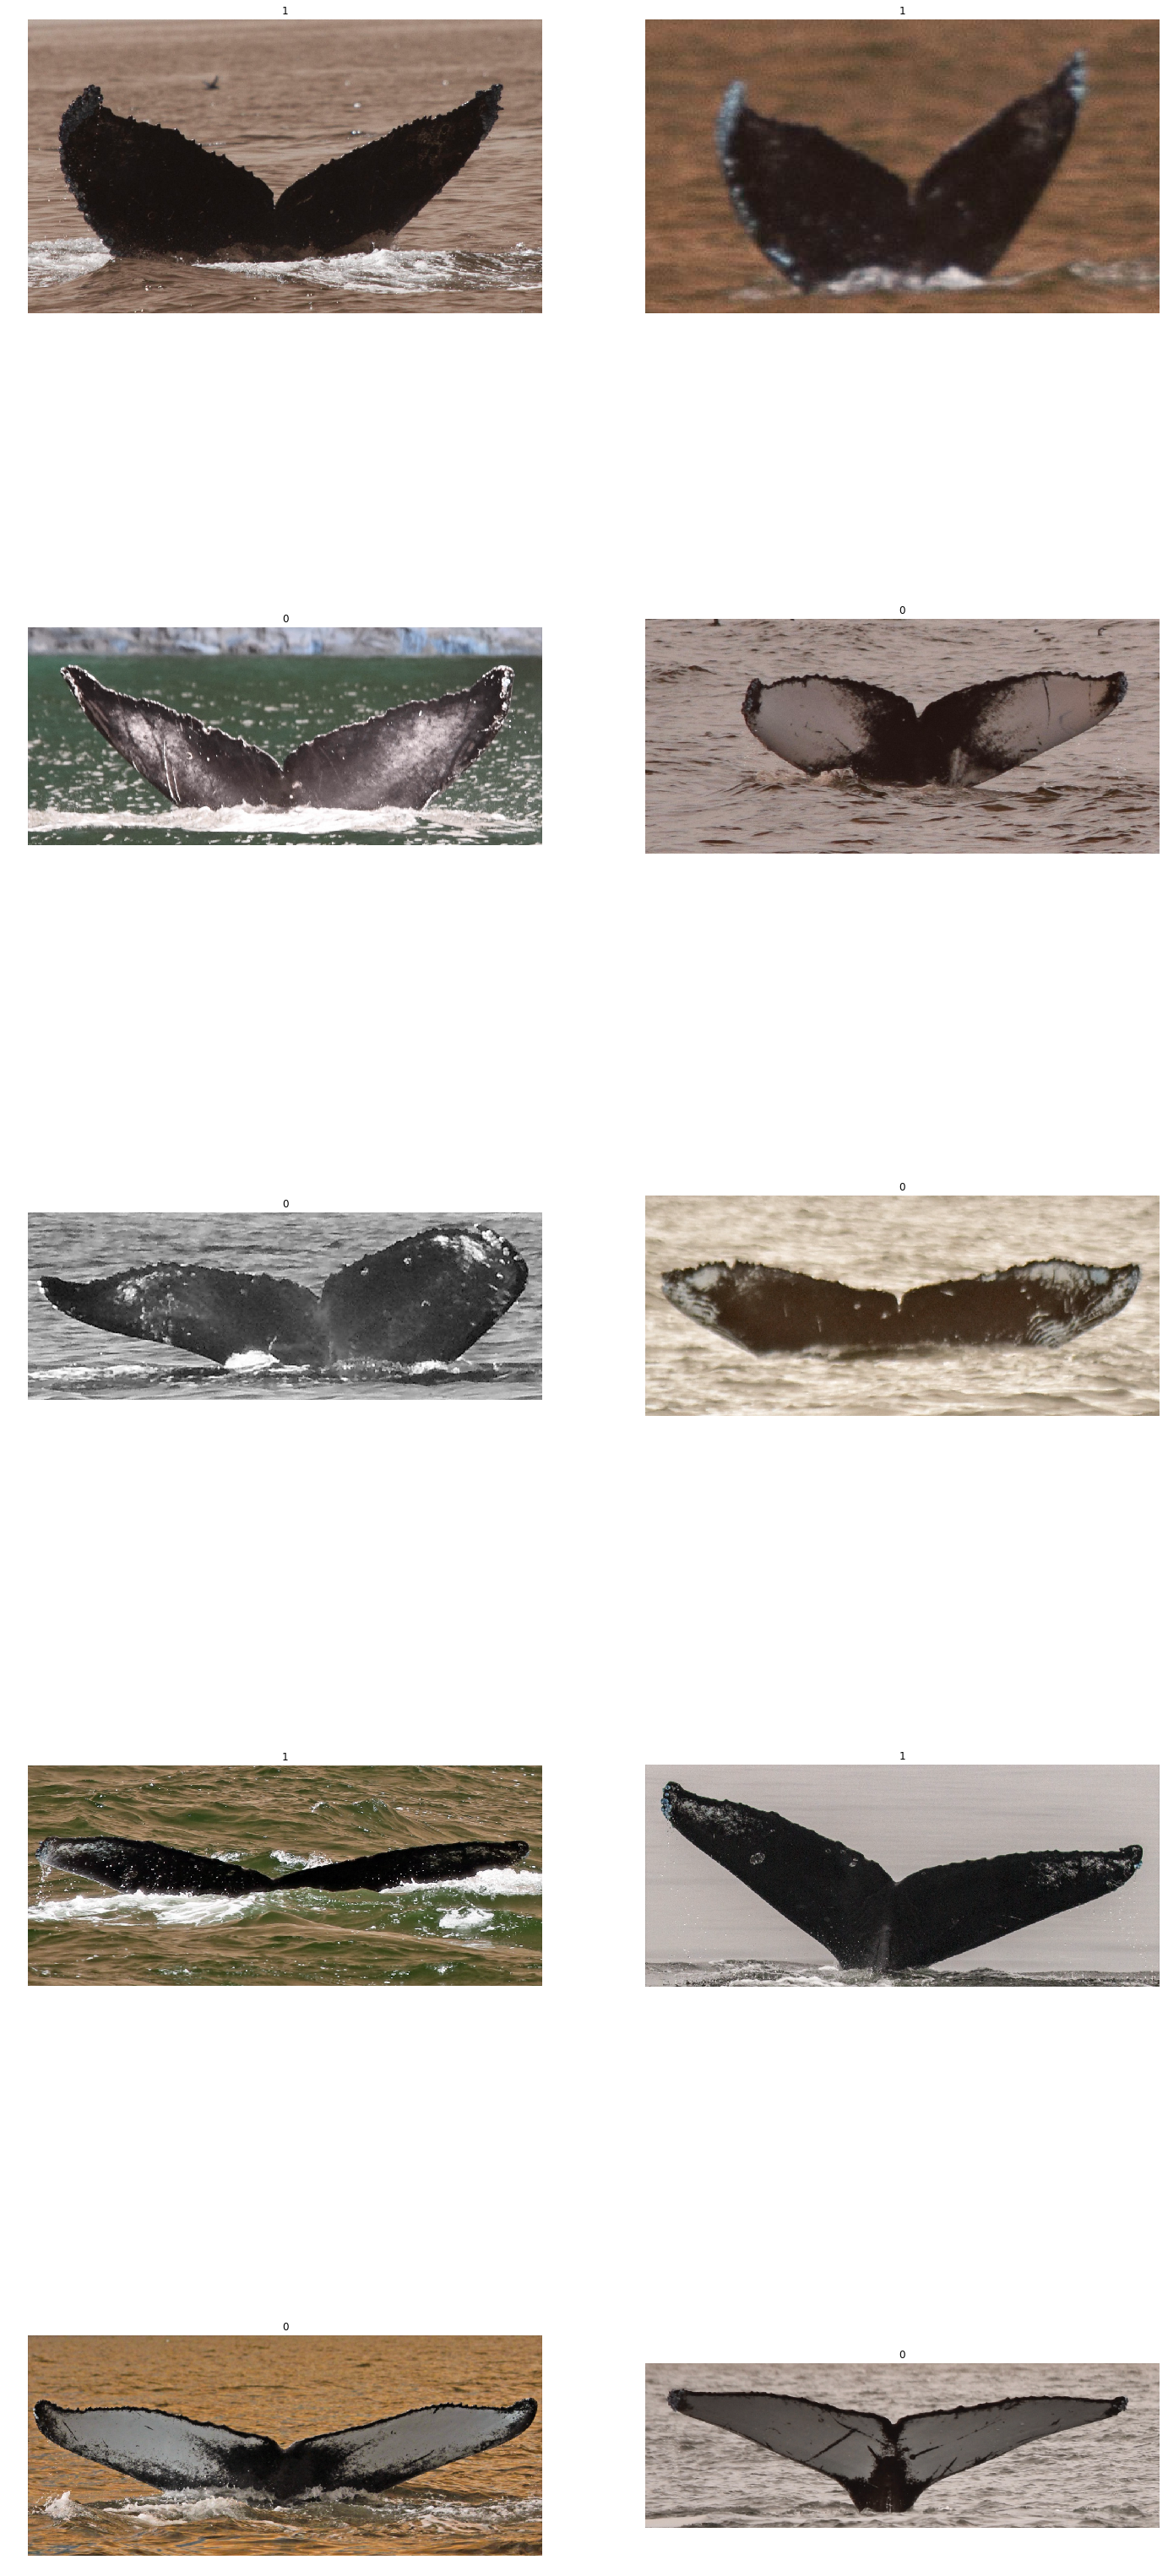

In [7]:
#look at some examples

#look at examples
imgs=triples_data[50:60]
per_row=2
rows=5
cols = 2
fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
for ax in axes.flatten(): 
    ax.axis('off')

left=0
j=0
for i,ax in enumerate(axes.flatten()):
#     print(j)
#     print(left)
    img=imgs[j][left]
    label=imgs[j][2]
    image_path=os.path.join(TRAIN_IMG, img)
    left=(left+1)%2
    if (i+1)%2==0:
        j=j+1
#     print(image_path)
    ax.imshow(cv2.imread(image_path))
    ax.set_title(label)

In [8]:
RESIZE_IMG = IM_SIZE
from skimage.transform import resize
from keras.utils import np_utils

def cached_imread(image_path, image_cache):
    if not image_path in image_cache:
        image = plt.imread(image_path).astype(np.float32)
#         print(image.shape)
        image = resize(image, (RESIZE_IMG, RESIZE_IMG,3))
        image_cache[image_path] = image
    return image_cache[image_path]

def preprocess_images(image_names, seed, datagen, image_cache):
    np.random.seed(seed)
    X = np.zeros((len(image_names), RESIZE_IMG, RESIZE_IMG, 3))
    for i, image_name in enumerate(image_names):
#         print(image_name)
        if os.path.isfile(image_name):
            image = cached_imread(image_name, image_cache)
        else:
            image = cached_imread(os.path.join(TRAIN_IMG, image_name), image_cache)
        if datagen is not None:
            X[i] = datagen.random_transform(image)
        else:
            X[i]=image
#     #for test
#     scaler = StandardScaler()
#     scaled_X = scaler.fit_transform(X)
    return X

def image_triple_generator(image_triples, batch_size):
    #should remove rescale=1./255?!
    datagen_args = dict(rescale=1./255,rotation_range=10,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
    datagen_left = ImageDataGenerator(**datagen_args)
    datagen_right = ImageDataGenerator(**datagen_args)
    image_cache = {}
    
    while True:
        # loop once per epoch
        num_recs = len(image_triples)
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            # loop once per batch
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            batch = [image_triples[i] for i in batch_indices]
            # make sure image data generators generate same transformations
            seed = np.random.randint(low=0, high=1000, size=1)[0]
            Xleft = preprocess_images([b[0] for b in batch], seed, 
                                      datagen_left, image_cache)
            Xright = preprocess_images([b[1] for b in batch], seed,
                                       datagen_right, image_cache)
            Y = np.array([b[2] for b in batch]) # 0 or 1
#             Y = np_utils.to_categorical(np.array([b[2] for b in batch])) # 0 or 1

            yield ([Xleft, Xright], Y)


In [9]:
triples_batch_gen = image_triple_generator(triples_data, 32)
([Xleft, Xright], Y) = triples_batch_gen.__next__()
print("generator output shapes:")
print(Xleft.shape, Xright.shape, Y.shape)

generator output shapes:
(32, 150, 150, 3) (32, 150, 150, 3) (32,)


# Load pretrained model

In [10]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    # CONV => RELU => POOL
    seq.add(Conv2D(20, kernel_size=5, padding="same", input_shape=input_shape,activation='relu'))
    seq.add(BatchNormalization())
#     seq.add(Activation("relu"))
    seq.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    seq.add(BatchNormalization())
    # CONV => RELU => POOL
    seq.add(Conv2D(50, kernel_size=5, padding="same",activation='relu'))
    seq.add(BatchNormalization())
#     seq.add(Activation("relu"))
    seq.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    seq.add(BatchNormalization())
    # Flatten => RELU
    seq.add(Flatten())
    seq.add(Dense(500))
    
    return seq

In [11]:
from keras import backend as K

def cosine_distance(vecs, normalize=False):
    x, y = vecs
    if normalize:
        x = K.l2_normalize(x, axis=0)
        y = K.l2_normalize(x, axis=0)
    return K.prod(K.stack([x, y], axis=1), axis=1)

def cosine_distance_output_shape(shapes):
    return shapes[0]

def compute_accuracy(preds, labels):
    return labels[preds.ravel() < 0.5].mean()

In [12]:
image_size=IM_SIZE
input_shape = (image_size,image_size, 3)
base_network = create_base_network(input_shape)
# input_tensor_l = Input(shape=input_shape)
# input_tensor_r = Input(shape=input_shape)

# vector_left = base_network(input_tensor_l)
# vector_right = base_network(input_tensor_r)

input_shape = (image_size,image_size, 3)
vector_left =Input(shape=base_network.output_shape[1:])
vector_right = Input(shape=base_network.output_shape[1:])
img_l = Input(shape=input_shape)
img_r = Input(shape=input_shape)
x_l         = base_network(img_l)
x_r         = base_network(img_r)

In [ ]:

# # # load 2 copies of the Xception model
# # # in case of a siamese network, the same instance of the network will be trained,
# # # but in our case the network is untrainable, so we can have 2 copies
# # #TBD-include_top=True?!
# CLASSES = len(np.unique(train_lbl['Id'])) -1
# image_size=IM_SIZE
# base_network = Xception(weights='imagenet', include_top=True,input_shape = (image_size,image_size, 3))
# input_shape = (image_size,image_size, 3)


# vector_left =Input(shape=base_network.output_shape[1:])
# vector_right = Input(shape=base_network.output_shape[1:])


# img_l = Input(shape=input_shape)
# img_r = Input(shape=input_shape)
# x_l         = base_network(img_l)
# x_r         = base_network(img_r)

In [ ]:
# for layer in base_network.layers:
#     print(layer.name, layer.input_shape, layer.output_shape)

# Define head model

In [13]:
#layer to merge two encoded inputs with the l1 distance between them
mid        = 32
L_prod = Lambda(lambda x : x[0]*x[1])([vector_left, vector_right])
L_sum = Lambda(lambda x : x[0] + x[1])([vector_left, vector_right])
L1_distance= Lambda(lambda x : K.abs(x[0] - x[1]))([vector_left, vector_right])
L2_distance= Lambda(lambda x : K.square(x[0] - x[1]))([vector_left, vector_right])
distance= Concatenate()([L_prod, L_sum, L1_distance, L2_distance])
distance= Reshape((4, base_network.output_shape[1], 1), name='reshape1')(distance)
x          = Conv2D(mid, (4, 1), activation='relu', padding='valid')(distance)
x          = Reshape((base_network.output_shape[1], mid, 1))(x)
x          = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
x          = Flatten(name='flatten')(x)
pred          = Dense(1, use_bias=True, activation='sigmoid', name='weighted-average',kernel_initializer="random_normal")(x)
head_model = Model([vector_left, vector_right], outputs=pred, name='head')

x          = head_model([x_l, x_r])
siamese_model      = Model(inputs=[img_l, img_r], outputs= x)
siamese_model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])


# TRAIN


In [14]:
from sklearn.model_selection import train_test_split
triples_train,triples_test =train_test_split(triples_data, test_size=0.1, random_state=42)

In [15]:
callbacks=[
    ReduceLROnPlateau(monitor='val_loss',patience=5,min_lr=1e-9,verbose=1,mode='min'),
    ModelCheckpoint('siamese_mid.h5',monitor='val_loss',save_best_only=True,verbose=1)
]

In [16]:
BATCH_SIZE=32
NUM_EPOCHS=5

image_cache = {}

train_gen = image_triple_generator(triples_train, BATCH_SIZE)
val_gen = image_triple_generator(triples_test, BATCH_SIZE)



# num_train_steps = len(triples_train) // BATCH_SIZE
# num_val_steps = len(triples_test) // BATCH_SIZE
num_train_steps = 100
num_val_steps = 40

history = siamese_model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=NUM_EPOCHS,
                              validation_data=val_gen,
                              validation_steps=num_val_steps,
                                      callbacks=callbacks)

siamese_model.save('siamese_trained.h5')


Epoch 1/3
100/100 [==============================] - 681s 7s/step - loss: 0.7043 - acc: 0.5375 - val_loss: 0.6611 - val_acc: 0.6055

Epoch 00001: val_loss improved from inf to 0.66105, saving model to siamese_mid.h5
Epoch 2/3
100/100 [==============================] - 435s 4s/step - loss: 0.6722 - acc: 0.5859 - val_loss: 0.6943 - val_acc: 0.5766

Epoch 00002: val_loss did not improve from 0.66105
Epoch 3/3
100/100 [==============================] - 317s 3s/step - loss: 0.6705 - acc: 0.5922 - val_loss: 0.6713 - val_acc: 0.6031

Epoch 00003: val_loss did not improve from 0.66105


# Evaluation & submission

In [20]:
def fetch_whale_img_list(train_df,new_whale=True):
    if not new_whale:
        kindlist=train_df[train_df['Id']!='new_whale'].groupby('Id').size()
    else:
        kindlist=train_df.groupby('Id').size()
    kindimgpathlist={}
    for whale in kindlist.index:
        if whale in kindimgpathlist:
            kindimgpathlist[whale].append(list(train_df['Image'][train_df['Id']==whale]))
        else:
            kindimgpathlist[whale]=[list(train_df['Image'][train_df['Id']==whale])]
    return kindimgpathlist

def pick_h(whale_imgs):
    pid = np.random.choice(np.arange(len(whale_imgs)), size=1)[0]
    return whale_imgs[pid]

In [21]:
submission_file='submission.csv'
whales_train_list=fetch_whale_img_list(train_lbl,new_whale=False)
test_scr={}
test_paths=os.listdir(TEST_IMG)

In [ ]:
scors={}
tst_img='6d792e3e6.jpg'
tst_img_path=os.path.join(TEST_IMG, tst_img)
whale='w_2ff0834'
imgs=[['74d501063.jpg',
   '896378efc.jpg',
   '9d931b246.jpg',
   '9f41722eb.jpg',
   'd2f89c5eb.jpg']]
wimg=pick_h(imgs)[0]
wimg_path=os.path.join(TRAIN_IMG, wimg)
[X1test, X2test]=preprocess_images([tst_img_path,wimg_path], np.random.randint(low=0, high=1000, size=1)[0], None, {})
X1test=X1test.reshape((1, IM_SIZE, IM_SIZE, 3))
X2test=X2test.reshape((1, IM_SIZE, IM_SIZE, 3))
scors[whale]= siamese_model.predict([X1test, X2test])
# wimg='74d501063.jpg'

In [ ]:

# test_df- test images
# test_scr={}
# for tst_img in test_paths[:2]:
#     print("test img:"+tst_img)
#     tst_img_path=os.path.join(TEST_IMG, tst_img)
#     scors={}
#     i=0
#     for whale, imgs in tqdm(whales_train_list.items()):
# #         if i%1000==0:
# #             print(i)
# #         i=1+1
#         wimg=pick_h(imgs)[0]
#         wimg_path=os.path.join(TRAIN_IMG, wimg)
#         [X1test, X2test]=preprocess_images([tst_img_path,wimg_path], np.random.randint(low=0, high=1000, size=1)[0], None, {})
#         X1test=X1test.reshape((1, IM_SIZE, IM_SIZE, 3))
#         X2test=X2test.reshape((1, IM_SIZE, IM_SIZE, 3))
#         scors[whale]= siamese_model.predict([X1test, X2test])
#     scores_sorted=OrderedDict(sorted(scors.items(), key=lambda t: t[0]))
#     test_scr[tst_img]=scores_sorted

In [18]:
#test output
siamese_model.predict_generator(train_gen,verbose = 1,steps=1,workers=1)

1/1 [==============================] - 1s 1s/step


array([[0.4291249 ],
       [0.59565   ],
       [0.55046463],
       [0.61834896],
       [0.35946834],
       [0.6410094 ],
       [0.46312448],
       [0.33790082],
       [0.5984514 ],
       [0.5503748 ],
       [0.6640633 ],
       [0.66079485],
       [0.7541426 ],
       [0.46572453],
       [0.343439  ],
       [0.5175542 ],
       [0.7026326 ],
       [0.5455837 ],
       [0.45669916],
       [0.6751562 ],
       [0.6613508 ],
       [0.45152852],
       [0.49126038],
       [0.63368547],
       [0.35156122],
       [0.7841012 ],
       [0.4657474 ],
       [0.4521166 ],
       [0.5270645 ],
       [0.5036126 ],
       [0.47381654],
       [0.349432  ]], dtype=float32)

In [ ]:
    #TODO- write line to submission file!

IRRELEVANT

In [ ]:
# from imagehash import phash
# from tqdm import tqdm_notebook as tqdm
# import pickle

# tagged = dict([(p, w) for _, p, w in train_lbl.to_records()])
# submit = [p for _, p, _ in SUB_Df.to_records()]
# join = list(tagged.keys()) + submit

In [ ]:
# def expand_path(p):
#     if os.path.isfile(os.path.join(TRAIN_IMG, p)):
#         return os.path.join(TRAIN_IMG, p)
#     if os.path.isfile(os.path.join(TEST_IMG,p)):
#         return os.path.join(TEST_IMG,p)
#     return None

In [ ]:
# # check if 2 given phashes are similar image in terms of mean and veriance 
# def match(hash1, hash2):
#     for p1 in h2ps[hash1]:
#         for p2 in h2ps[hash2]:
#             i1 = pil_image.open(expand_path(p1))
#             i2 = pil_image.open(expand_path(p2))
#             if i1.mode != i2.mode or i1.size != i2.size: return False
#             a1 = np.array(i1)
#             a1 = a1 - a1.mean()
#             a1 = a1 / sqrt((a1 ** 2).mean())
#             a2 = np.array(i2)
#             a2 = a2 - a2.mean()
#             a2 = a2 / sqrt((a2 ** 2).mean())
#             a = ((a1 - a2) ** 2).mean()
#             if a > 0.1: return False
#     return True

In [ ]:
# # Compute phash for each image in the training and test set.
# # load images into dictionary : {whale_id: (whale train images)}
# #  hash algorithms describe a class of comparable hash functions. Features in the image are used to generate a distinct (but not unique) fingerprint, and these fingerprints are comparable.
# # perceptual hashes can be compared -- giving you a sense of similarity between the two data sets.
# # read further here: http://www.hackerfactor.com/blog/index.php?/archives/432-Looks-Like-It.html

# p2h = {}
# for p in tqdm(join):
#     path=expand_path(p)
#     if path is None: 
#         print (p)
#         continue
#     img = pil_image.open(path)
#     h = phash(img)
#     p2h[p] = h

# # Find all images associated with a given phash value.
# h2ps = {}
# for p, h in p2h.items():
#     if h not in h2ps: h2ps[h] = []
#     if p not in h2ps[h]: h2ps[h].append(p)

# # Find all distinct phash values
# hs = list(h2ps.keys())

In [ ]:
# # If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
# h2h = {}
# for i, h1 in enumerate(tqdm(hs)):
#     for h2 in hs[:i]:
#         if h1 - h2 <= 6 and match(h1, h2):
#             s1 = str(h1)
#             s2 = str(h2)
#             if s1 < s2: s1, s2 = s2, s1
#             h2h[s1] = s2

In [ ]:
# # Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
# for p, h in p2h.items():
#     h = str(h)
#     if h in h2h: h = h2h[h]
#     p2h[p] = h
# with open(P2H_OUT, 'wb') as f:
#     pickle.dump(p2h, f)
# # For each image id, determine the list of pictures
# h2ps = {}
# for p, h in p2h.items():
#     if h not in h2ps: h2ps[h] = []
#     if p not in h2ps[h]: h2ps[h].append(p)

In [ ]:
# p2size = {}
# for p in tqdm(join):
#     size = pil_image.open(expand_path(p)).size
#     p2size[p] = size

In [ ]:
# # For each images id, select single image to be compared to in the siamese model
# def pick_picture_for_class(class_images):
#     if len(ps) == 1: return ps[0]
#     best_p = ps[0]
#     best_s = p2size[best_p]
#     for i in range(1, len(ps)):
#         p = ps[i]
#         s = p2size[p]
#         if s[0] * s[1] > best_s[0] * best_s[1]:  # Select the image with highest resolution
#             best_p = p
#             best_s = s
#     return best_p

# h2p = {}
# for h, ps in h2ps.items():
#     h2p[h] = pick_picture_for_class(ps)
# len(h2p), list(h2p.items())[:5]

In [ ]:
# #find relevant class labels for each hash value(hash to whales), exclude new_whale class
# h2ws = {}
# new_whale = 'new_whale'

# #for each picture and it's hash valu
# for p, w in tagged.items():
#     if w != new_whale:  # Use only identified whales
#         h = p2h[p] #get hash for picture
#         if h not in h2ws: h2ws[h] = [] 
#         if w not in h2ws[h]: h2ws[h].append(w) #add whale label to hash

# # for each hash value and whale label
# # For each whale, find the unambiguous images ids.
# w2hs = {}
# for h, ws in h2ws.items():
#     if len(ws) > 1:
#         h2ws[h] = sorted(ws)
#     if len(ws) == 1:  # Use only unambiguous pictures
#         w = ws[0]
#         if w not in w2hs: w2hs[w] = []
#         if h not in w2hs[w]: w2hs[w].append(h)
# for w, hs in w2hs.items():
#     if len(hs) > 1:
#         w2hs[w] = sorted(hs)

In [ ]:
# train = []  # A list of training image ids
# for hs in w2hs.values():
#     if len(hs) > 1:
#         train += hs
# random.shuffle(train)
# train_set = set(train)

# w2ts = {}  # Associate the image ids from train to each whale id.
# for w, hs in w2hs.items():
#     for h in hs:
#         if h in train_set:
#             if w not in w2ts:
#                 w2ts[w] = []
#             if h not in w2ts[w]:
#                 w2ts[w].append(h)
# for w, ts in w2ts.items():
#     w2ts[w] = np.array(ts)

# t2i = {}  # The position in train of each training image id
# for i, t in enumerate(train):
#     t2i[t] = i

In [ ]:
match      = []
unmatch    = []
# Compute a derangement for matching whales
for ts in w2ts.values():
    d = ts.copy()
    while True:
        random.shuffle(d)
        if not np.any(ts == d): break
        for ab in zip(ts,d): match.append(ab)

# Construct unmatched whale pairs from the LAP solution.
y = np.arange(len(w2ts),dtype=np.int32)

for i,j in zip(x,y):
    if i == j:
        print(x)
        print(y)
        print(i,j)
    assert i != j
    unmatch.append((train[i],train[j]))

random.shuffle(match)
random.shuffle(unmatch)

In [ ]:
# class TrainingData(Sequence):
#     def __init__(self, score, steps=1000, batch_size=32):
#         """
#         @param score the cost matrix for the picture matching
#         @param steps the number of epoch we are planning with this score matrix
#         """
#         super(TrainingData, self).__init__()
#         self.score = -score  # Maximizing the score is the same as minimuzing -score.
#         self.steps = steps
#         self.batch_size = batch_size
#         for ts in w2ts.values():
#             idxs = [t2i[t] for t in ts]
#             for i in idxs:
#                 for j in idxs:
#                     # Set a large value for matching whales -- eliminates this potential pairing
#                     self.score[i, j] = 10000.0  
#         self.on_epoch_end()

#     def __getitem__(self, index):
#         start = self.batch_size * index
#         end = min(start + self.batch_size, len(self.match) + len(self.unmatch))
#         size = end - start
#         assert size > 0
#         a = np.zeros((size,) + img_shape, dtype=K.floatx())
#         b = np.zeros((size,) + img_shape, dtype=K.floatx())
#         c = np.zeros((size, 1), dtype=K.floatx())
#         j = start // 2
#         for i in range(0, size, 2):
#             a[i, :, :, :] = read_for_training(self.match[j][0])
#             b[i, :, :, :] = read_for_training(self.match[j][1])
#             c[i, 0] = 1  # This is a match
#             a[i + 1, :, :, :] = read_for_training(self.unmatch[j][0])
#             b[i + 1, :, :, :] = read_for_training(self.unmatch[j][1])
#             c[i + 1, 0] = 0  # Different whales
#             j += 1
#         return [a, b], c

#     def on_epoch_end(self):
#         if self.steps <= 0: return  # Skip this on the last epoch.
#         self.steps -= 1
#         self.match = []
#         self.unmatch = []
#         _, _, x = lapjv(self.score)  # Solve the linear assignment problem
#         y = np.arange(len(x), dtype=np.int32)

#         # Compute a derangement for matching whales
#         for ts in w2ts.values():
#             d = ts.copy()
#             while True:
#                 random.shuffle(d)
#                 if not np.any(ts == d): break
#             for ab in zip(ts, d): self.match.append(ab)
#         print(self.match)

#         # Construct unmatched whale pairs from the LAP solution.
#         for i, j in zip(x, y):
#             if i == j:
#                 print(self.score)
#                 print(x)
#                 print(y)
#             print(i, j)
#             assert i != j
#             self.unmatch.append((train[i], train[j]))

#         # Force a different choice for an eventual next epoch.
#         self.score[x, y] = 10000.0
#         self.score[y, x] = 10000.0
#         random.shuffle(self.match)
#         random.shuffle(self.unmatch)
#         # print(len(self.match), len(train), len(self.unmatch), len(train))
#         assert len(self.match) == len(train) and len(self.unmatch) == len(train)

#     def __len__(self):
#         return (len(self.match) + len(self.unmatch) + self.batch_size - 1) // self.batch_size


# # Test on a batch of 32 with random costs.
# score = np.random.random_sample(size=(len(train), len(train)))
# data = TrainingData(score)
# (a, b), c = data[0]